# Association Rule Mining (ARM): Symptoms and Diseases  
**Project Goal:** Discover meaningful patterns in symptom combinations and extract association rules that can support structured insights (e.g., common co-occurring symptoms and symptom patterns strongly linked to particular diseases).

This notebook is written to be **presentation-ready**:
- clear methodology and metrics (support, confidence, lift, leverage)
- clean, readable visualizations
- concise interpretation and limitations

> **Important:** This analysis is for data mining practice and pattern discovery only. It is not medical advice or a diagnostic tool.


In [1]:
%pip install -q pandas numpy matplotlib networkx
import pandas as pd
import numpy as np
import re, math, itertools
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

# Optional (used for the network visualization)
import networkx as nx

# ---------- Load cleaned dataset (preferred) ----------
CANDIDATES = [
    Path("outputs/dataset_cleaned.csv"),
    Path("dataset_cleaned.csv"),
    Path("/mnt/data/dataset_cleaned.csv"),
    Path("dataset.csv"),
    Path("/mnt/data/dataset.csv"),
]

DATA_PATH = next((p for p in CANDIDATES if p.exists()), None)
if DATA_PATH is None:
    raise FileNotFoundError("Could not find a dataset file. Run the cleaning notebook first or place dataset.csv beside this notebook.")

df = pd.read_csv(DATA_PATH)
symptom_cols = [c for c in df.columns if c.lower().startswith("symptom")]

# Minimal safety-clean (in case a raw dataset.csv is loaded here)
def clean_symptom_token(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    x = x.replace("_", " ")
    x = re.sub(r"\s+", " ", x).strip()
    return x.lower()

for c in symptom_cols:
    df[c] = df[c].apply(clean_symptom_token)
df["Disease"] = df["Disease"].astype(str).str.strip()

# Build transactions
sym_transactions = []
sym_dis_transactions = []

for _, row in df.iterrows():
    items = [x for x in row[symptom_cols].values.tolist() if isinstance(x, str) and x.strip()]
    items = sorted(set(items))
    if len(items) >= 2:
        sym_transactions.append(items)
    sym_dis_transactions.append(items + [f"disease::{row['Disease']}"])

N = len(sym_dis_transactions)

print("Loaded:", DATA_PATH)
print("Rows (transactions):", N)
print("Diseases:", df["Disease"].nunique())
print("Unique symptoms:", len({s for t in sym_transactions for s in t}))


Note: you may need to restart the kernel to use updated packages.
Loaded: outputs/dataset_cleaned.csv
Rows (transactions): 4920
Diseases: 41
Unique symptoms: 131


## Dataset overview

We treat each row as a **transaction** (a basket of symptoms). The dataset contains balanced disease labels, which is useful for pattern discovery but affects how some rule metrics (especially lift) behave.


count    4920.000000
mean        7.448780
std         3.592166
min         3.000000
25%         5.000000
50%         6.000000
75%        10.000000
max        17.000000
Name: symptoms_per_transaction, dtype: float64

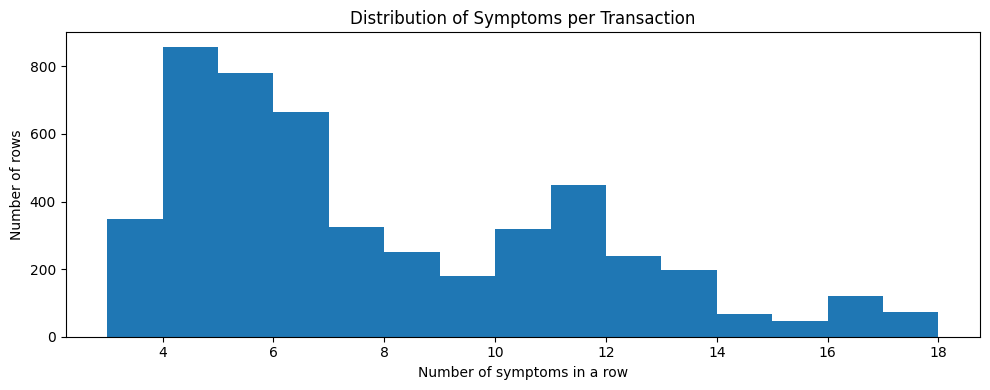

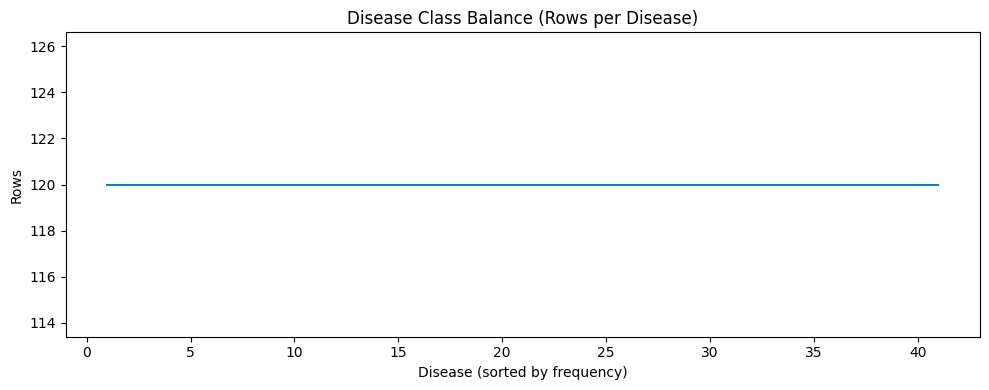

Disease
Fungal infection                120
Hepatitis C                     120
Hepatitis E                     120
Alcoholic hepatitis             120
Tuberculosis                    120
Common Cold                     120
Pneumonia                       120
Dimorphic hemmorhoids(piles)    120
Heart attack                    120
Varicose veins                  120
Name: count, dtype: int64

In [2]:
# Transaction size distribution
sizes = [len(t) for t in sym_transactions]
sizes_s = pd.Series(sizes, name="symptoms_per_transaction")
display(sizes_s.describe())

plt.figure(figsize=(10,4))
plt.hist(sizes, bins=range(min(sizes), max(sizes)+2))
plt.title("Distribution of Symptoms per Transaction")
plt.xlabel("Number of symptoms in a row")
plt.ylabel("Number of rows")
plt.tight_layout()
plt.show()

# Disease balance check
disease_counts = df["Disease"].value_counts()
plt.figure(figsize=(10,4))
plt.plot(range(1, len(disease_counts)+1), sorted(disease_counts.values, reverse=True))
plt.title("Disease Class Balance (Rows per Disease)")
plt.xlabel("Disease (sorted by frequency)")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

display(disease_counts.head(10))


## Visual 1 — Most frequent symptoms (baseline)

This chart shows which symptoms appear most often overall. It sets context for later analysis because high-frequency symptoms naturally appear in many co-occurrences and rules.


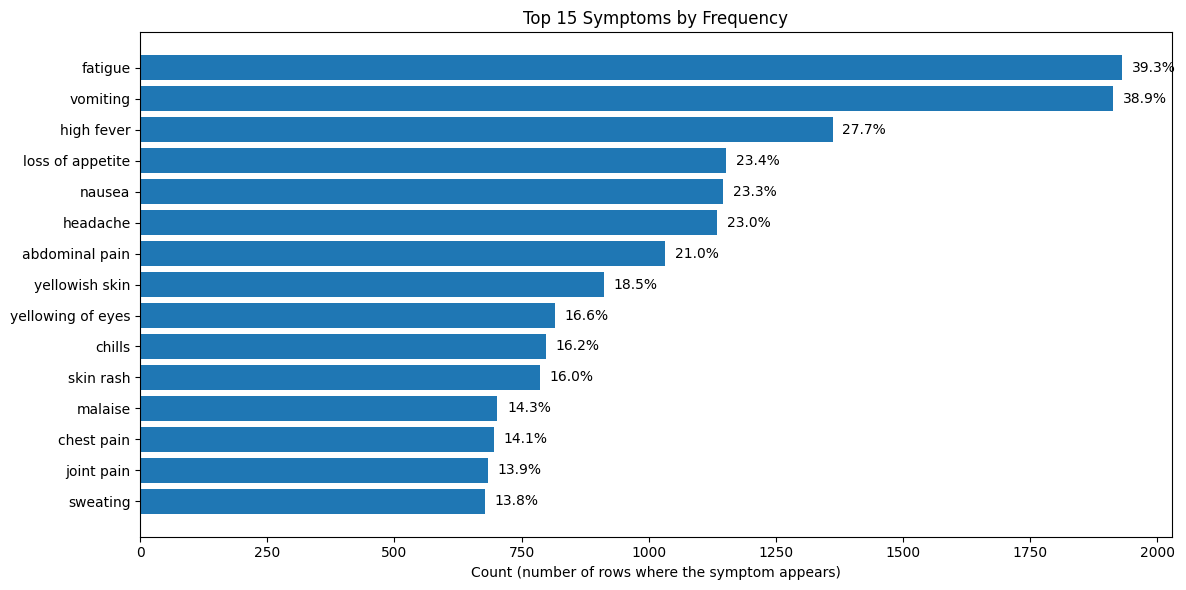

,symptom,count,support
30,fatigue,1932,0.392683
13,vomiting,1914,0.389024
25,high fever,1362,0.276829
15,loss of appetite,1152,0.234146
16,nausea,1146,0.232927
45,headache,1134,0.230488
14,abdominal pain,1032,0.209756
18,yellowish skin,912,0.185366
17,yellowing of eyes,816,0.165854
4,chills,798,0.162195


In [3]:
# Symptom frequency
c1 = Counter()
for t in sym_transactions:
    c1.update(t)

freq_df = pd.DataFrame(c1.items(), columns=["symptom", "count"]).sort_values("count", ascending=False)
freq_df["support"] = freq_df["count"] / N

top = freq_df.head(15).iloc[::-1]

plt.figure(figsize=(12,6))
plt.barh(top["symptom"], top["count"])
plt.title("Top 15 Symptoms by Frequency")
plt.xlabel("Count (number of rows where the symptom appears)")
for i, (sym, cnt, sup) in enumerate(zip(top["symptom"], top["count"], top["support"])):
    plt.text(cnt + (top["count"].max()*0.01), i, f"{sup:.1%}", va="center")
plt.tight_layout()
plt.show()

display(freq_df.head(12))

## Visual 2 — Symptom similarity heatmap (Jaccard)

Instead of raw co-occurrence counts, this heatmap uses **Jaccard similarity**:

\[
J(A,B)=\frac{|A \cap B|}{|A|+|B|-|A \cap B|}
\]

This makes comparisons fairer because it accounts for symptom frequency. Values closer to 1 mean two symptoms frequently appear together relative to how often they appear overall.


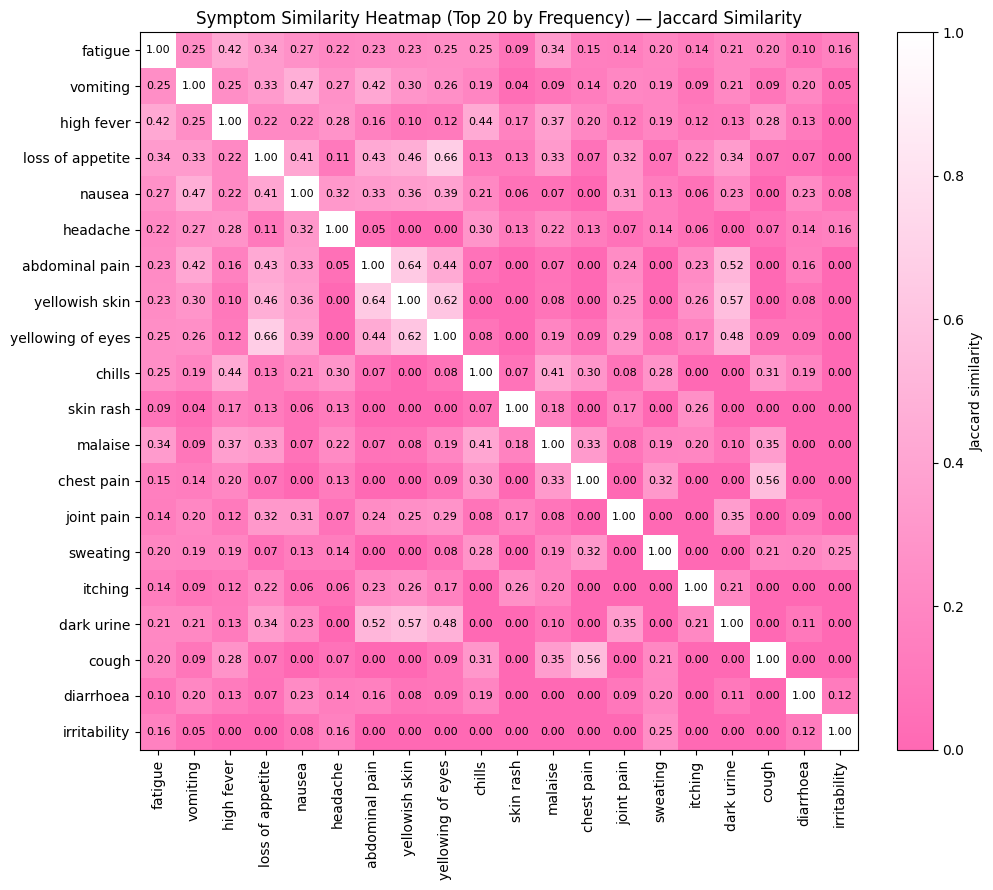

In [4]:
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

top_k = 20
top_syms = list(freq_df.head(top_k)["symptom"])
idx = {s:i for i,s in enumerate(top_syms)}

# Count occurrences of each top symptom
occ = Counter()
for t in sym_transactions:
    for s in set(t):
        if s in idx:
            occ[s] += 1

# Co-occurrence matrix for top symptoms
M = np.zeros((top_k, top_k), dtype=int)
for t in sym_transactions:
    items = [s for s in set(t) if s in idx]
    for a, b in itertools.combinations(items, 2):
        i, j = idx[a], idx[b]
        M[i, j] += 1
        M[j, i] += 1

# Jaccard similarity matrix
J = np.zeros((top_k, top_k), dtype=float)
for i, a in enumerate(top_syms):
    for j, b in enumerate(top_syms):
        if i == j:
            J[i, j] = 1.0
        else:
            inter = M[i, j]
            union = occ[a] + occ[b] - inter
            J[i, j] = inter / union if union else 0.0

# Custom colormap: low = pink, high = white
pink_to_white = LinearSegmentedColormap.from_list(
    "pink_to_white",
    ["#ff69b4", "#ffffff"]  # hot pink -> white
)

plt.figure(figsize=(11, 9))
im = plt.imshow(J, cmap=pink_to_white, vmin=0, vmax=1)

plt.title("Symptom Similarity Heatmap (Top 20 by Frequency) — Jaccard Similarity")
plt.xticks(range(top_k), top_syms, rotation=90)
plt.yticks(range(top_k), top_syms)

cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("Jaccard similarity")

# Add numbers to each cell
for i in range(top_k):
    for j in range(top_k):
        val = J[i, j]
        # Use black text for readability (pink->white stays readable)
        plt.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8, color="black")

plt.tight_layout()
plt.show()

## Rule mining setup

We mine two types of rules:

1) **Symptom → Symptom** (within symptom-only transactions)  
2) **Symptoms → Disease** (adds a disease item like `disease::Diabetes` to each transaction)

**Metrics used**
- **Support:** fraction of rows containing *antecedent ∪ consequent*
- **Confidence:** \( P(consequent | antecedent) \)
- **Lift:** confidence divided by consequent support  
- **Leverage:** difference between observed and expected co-occurrence (useful when lift is inflated by balanced labels)

Because disease labels are evenly represented in this dataset, lift values for high-confidence symptom→disease rules can become very large. For that reason, we interpret symptom→disease rules mainly using **support, confidence, and leverage**, and treat lift as a validity check (lift > 1).


In [5]:
def is_disease(x: str) -> bool:
    return isinstance(x, str) and x.startswith("disease::")

# --------------------------
# A) Symptom -> Symptom rules
# --------------------------
N_sym = len(sym_transactions)
min_support_ss = 0.03
min_confidence_ss = 0.50
min_count_ss = math.ceil(min_support_ss * N_sym)

c1 = Counter()
c2 = Counter()
c3 = Counter()

for t in sym_transactions:
    items = sorted(set(t))
    c1.update(items)
    for a, b in itertools.combinations(items, 2):
        c2[(a, b)] += 1
    for comb in itertools.combinations(items, 3):
        c3[comb] += 1

def get_count_ss(itemset):
    itemset = tuple(itemset)
    if len(itemset) == 1:
        return c1[itemset[0]]
    if len(itemset) == 2:
        a, b = itemset
        if a > b:
            a, b = b, a
        return c2.get((a, b), 0)
    if len(itemset) == 3:
        return c3.get(tuple(sorted(itemset)), 0)
    return 0

rules_ss = []

# Pair rules (A->B and B->A)
for (a, b), cnt in c2.items():
    if cnt < min_count_ss:
        continue
    sup = cnt / N_sym

    conf_ab = cnt / get_count_ss((a,))
    if conf_ab >= min_confidence_ss:
        cons_sup = get_count_ss((b,)) / N_sym
        lift = conf_ab / cons_sup if cons_sup else np.nan
        lev = sup - (get_count_ss((a,)) / N_sym) * cons_sup
        rules_ss.append(((a,), (b,), sup, conf_ab, lift, lev, 1))

    conf_ba = cnt / get_count_ss((b,))
    if conf_ba >= min_confidence_ss:
        cons_sup = get_count_ss((a,)) / N_sym
        lift = conf_ba / cons_sup if cons_sup else np.nan
        lev = sup - (get_count_ss((b,)) / N_sym) * cons_sup
        rules_ss.append(((b,), (a,), sup, conf_ba, lift, lev, 1))

# Triple rules (AB -> C)
for itemset, cnt in c3.items():
    if cnt < min_count_ss:
        continue
    items = list(itemset)
    sup = cnt / N_sym
    for cons in items:
        ant = tuple(sorted([x for x in items if x != cons]))
        conf = cnt / get_count_ss(ant)
        if conf >= min_confidence_ss:
            cons_sup = get_count_ss((cons,)) / N_sym
            lift = conf / cons_sup if cons_sup else np.nan
            lev = sup - (get_count_ss(ant) / N_sym) * cons_sup
            rules_ss.append((ant, (cons,), sup, conf, lift, lev, len(ant)))

rules_ss_df = pd.DataFrame(rules_ss, columns=["antecedent","consequent","support","confidence","lift","leverage","antecedent_len"])
rules_ss_df["antecedent_str"] = rules_ss_df["antecedent"].apply(lambda t: ", ".join(t))
rules_ss_df["consequent_str"] = rules_ss_df["consequent"].apply(lambda t: t[0])

print("Symptom→Symptom rules:", len(rules_ss_df))
display(rules_ss_df.sort_values(["lift","support"], ascending=False).head(15))

# --------------------------
# B) Symptoms -> Disease rules
# --------------------------
min_support_sd = 0.02
min_confidence_sd = 0.40
min_count_sd = math.ceil(min_support_sd * N)

c1d = Counter()
c2d = Counter()
c3d = Counter()

for t in sym_dis_transactions:
    items = sorted(set(t))
    c1d.update(items)
    for a, b in itertools.combinations(items, 2):
        c2d[(a, b)] += 1
    for comb in itertools.combinations(items, 3):
        c3d[comb] += 1

def get_count_sd(itemset):
    itemset = tuple(itemset)
    if len(itemset) == 1:
        return c1d[itemset[0]]
    if len(itemset) == 2:
        a, b = itemset
        if a > b:
            a, b = b, a
        return c2d.get((a, b), 0)
    if len(itemset) == 3:
        return c3d.get(tuple(sorted(itemset)), 0)
    return 0

rules_sd = []

# From pairs: 1 symptom -> disease
for (a, b), cnt in c2d.items():
    if cnt < min_count_sd:
        continue
    if is_disease(a) ^ is_disease(b):
        ant = (a,) if not is_disease(a) else (b,)
        cons = (b,) if is_disease(b) else (a,)
        sup = cnt / N
        conf = cnt / get_count_sd(ant)
        cons_sup = get_count_sd(cons) / N
        lift = conf / cons_sup if cons_sup else np.nan
        lev = sup - (get_count_sd(ant) / N) * cons_sup
        rules_sd.append((ant, cons, sup, conf, lift, lev, 1))

# From triples: 2 symptoms -> disease
for itemset, cnt in c3d.items():
    if cnt < min_count_sd:
        continue
    dis = [x for x in itemset if is_disease(x)]
    if len(dis) != 1:
        continue
    disease = dis[0]
    syms = tuple(sorted([x for x in itemset if not is_disease(x)]))
    ant = syms
    cons = (disease,)
    sup = cnt / N
    conf = cnt / get_count_sd(ant)
    cons_sup = get_count_sd(cons) / N
    lift = conf / cons_sup if cons_sup else np.nan
    lev = sup - (get_count_sd(ant) / N) * cons_sup
    rules_sd.append((ant, cons, sup, conf, lift, lev, 2))

rules_sd_df = pd.DataFrame(rules_sd, columns=["antecedent","consequent","support","confidence","lift","leverage","antecedent_len"])
rules_sd_df["antecedent_str"] = rules_sd_df["antecedent"].apply(lambda t: ", ".join(t))
rules_sd_df["disease"] = rules_sd_df["consequent"].apply(lambda t: t[0].replace("disease::",""))

print("Symptoms→Disease rules:", len(rules_sd_df))
display(rules_sd_df.sort_values(["confidence","support"], ascending=False).head(15))


Symptom→Symptom rules: 1025


,antecedent,consequent,support,confidence,lift,leverage,antecedent_len,antecedent_str,consequent_str
136,"(abnormal menstruation,)","(mood swings,)",0.046341,0.950000,20.500000,0.044081,1,abnormal menstruation,mood swings
137,"(mood swings,)","(abnormal menstruation,)",0.046341,1.000000,20.500000,0.044081,1,mood swings,abnormal menstruation
1008,"(irritability, mood swings)","(abnormal menstruation,)",0.046341,1.000000,20.500000,0.044081,2,"irritability, mood swings",abnormal menstruation
1010,"(abnormal menstruation, irritability)","(mood swings,)",0.046341,0.950000,20.500000,0.044081,2,"abnormal menstruation, irritability",mood swings
1005,"(fatigue, mood swings)","(abnormal menstruation,)",0.042683,1.000000,20.500000,0.040601,2,"fatigue, mood swings",abnormal menstruation
458,"(headache, loss of appetite)","(red spots over body,)",0.045122,0.973684,20.472335,0.042918,2,"headache, loss of appetite",red spots over body
472,"(headache, skin rash)","(red spots over body,)",0.043902,0.972973,20.457380,0.041756,2,"headache, skin rash",red spots over body
522,"(loss of appetite, skin rash)","(red spots over body,)",0.043902,0.972973,20.457380,0.041756,2,"loss of appetite, skin rash",red spots over body
528,"(malaise, skin rash)","(red spots over body,)",0.043902,0.972973,20.457380,0.041756,2,"malaise, skin rash",red spots over body
141,"(painful walking,)","(swelling joints,)",0.043902,0.947368,20.443213,0.041755,1,painful walking,swelling joints


Symptoms→Disease rules: 1631


,antecedent,consequent,support,confidence,lift,leverage,antecedent_len,antecedent_str,disease
39,"(increased appetite,)","(disease::Diabetes,)",0.02439,1.0,41.0,0.023795,1,increased appetite,Diabetes
43,"(polyuria,)","(disease::Diabetes,)",0.02439,1.0,41.0,0.023795,1,polyuria,Diabetes
115,"(pain behind the eyes,)","(disease::Dengue,)",0.02439,1.0,41.0,0.023795,1,pain behind the eyes,Dengue
149,"(receiving blood transfusion,)","(disease::Hepatitis B,)",0.02439,1.0,41.0,0.023795,1,receiving blood transfusion,Hepatitis B
150,"(receiving unsterile injections,)","(disease::Hepatitis B,)",0.02439,1.0,41.0,0.023795,1,receiving unsterile injections,Hepatitis B
170,"(coma,)","(disease::Hepatitis E,)",0.02439,1.0,41.0,0.023795,1,coma,Hepatitis E
177,"(stomach bleeding,)","(disease::Hepatitis E,)",0.02439,1.0,41.0,0.023795,1,stomach bleeding,Hepatitis E
189,"(blood in sputum,)","(disease::Tuberculosis,)",0.02439,1.0,41.0,0.023795,1,blood in sputum,Tuberculosis
207,"(congestion,)","(disease::Common Cold,)",0.02439,1.0,41.0,0.023795,1,congestion,Common Cold
213,"(loss of smell,)","(disease::Common Cold,)",0.02439,1.0,41.0,0.023795,1,loss of smell,Common Cold


## Strongest rule examples (tables)

The tables below highlight the most reliable symptom→disease patterns:

- **single-symptom rules** are easier to interpret
- **two-symptom rules** can be more specific (higher confidence) but are less general

These are ranked using **confidence, support, and leverage**.


In [6]:
# Top single-symptom -> disease rules
top_single = (rules_sd_df[rules_sd_df["antecedent_len"] == 1]
              .sort_values(["confidence","support","leverage"], ascending=False)
              .head(15)
              .copy())

top_single = top_single[["antecedent_str","disease","support","confidence","lift","leverage"]]
display(top_single)

# Top two-symptom -> disease rules
top_pair = (rules_sd_df[rules_sd_df["antecedent_len"] == 2]
            .sort_values(["confidence","support","leverage"], ascending=False)
            .head(15)
            .copy())

top_pair = top_pair[["antecedent_str","disease","support","confidence","lift","leverage"]]
display(top_pair)


,antecedent_str,disease,support,confidence,lift,leverage
39,increased appetite,Diabetes,0.02439,1.0,41.0,0.023795
43,polyuria,Diabetes,0.02439,1.0,41.0,0.023795
115,pain behind the eyes,Dengue,0.02439,1.0,41.0,0.023795
149,receiving blood transfusion,Hepatitis B,0.02439,1.0,41.0,0.023795
150,receiving unsterile injections,Hepatitis B,0.02439,1.0,41.0,0.023795
170,coma,Hepatitis E,0.02439,1.0,41.0,0.023795
177,stomach bleeding,Hepatitis E,0.02439,1.0,41.0,0.023795
189,blood in sputum,Tuberculosis,0.02439,1.0,41.0,0.023795
207,congestion,Common Cold,0.02439,1.0,41.0,0.023795
213,loss of smell,Common Cold,0.02439,1.0,41.0,0.023795


,antecedent_str,disease,support,confidence,lift,leverage
402,"increased appetite, polyuria",Diabetes,0.02439,1.0,41.0,0.023795
605,"back pain, headache",Dengue,0.02439,1.0,41.0,0.023795
608,"back pain, loss of appetite",Dengue,0.02439,1.0,41.0,0.023795
610,"back pain, nausea",Dengue,0.02439,1.0,41.0,0.023795
611,"back pain, pain behind the eyes",Dengue,0.02439,1.0,41.0,0.023795
641,"headache, pain behind the eyes",Dengue,0.02439,1.0,41.0,0.023795
662,"loss of appetite, pain behind the eyes",Dengue,0.02439,1.0,41.0,0.023795
671,"nausea, pain behind the eyes",Dengue,0.02439,1.0,41.0,0.023795
789,"mild fever, muscle pain",hepatitis A,0.02439,1.0,41.0,0.023795
796,"muscle pain, yellowing of eyes",hepatitis A,0.02439,1.0,41.0,0.023795


## Visual 3 — Rule quality (support vs confidence)

This bubble chart compares symptom→disease rules:

- **x-axis:** support (how common the full pattern is)
- **y-axis:** confidence (how reliable the disease is given the symptoms)
- **bubble size:** leverage (how much more often the pattern occurs than expected by chance)

Marker shape indicates whether the rule uses **1 symptom** or **2 symptoms** in the antecedent.


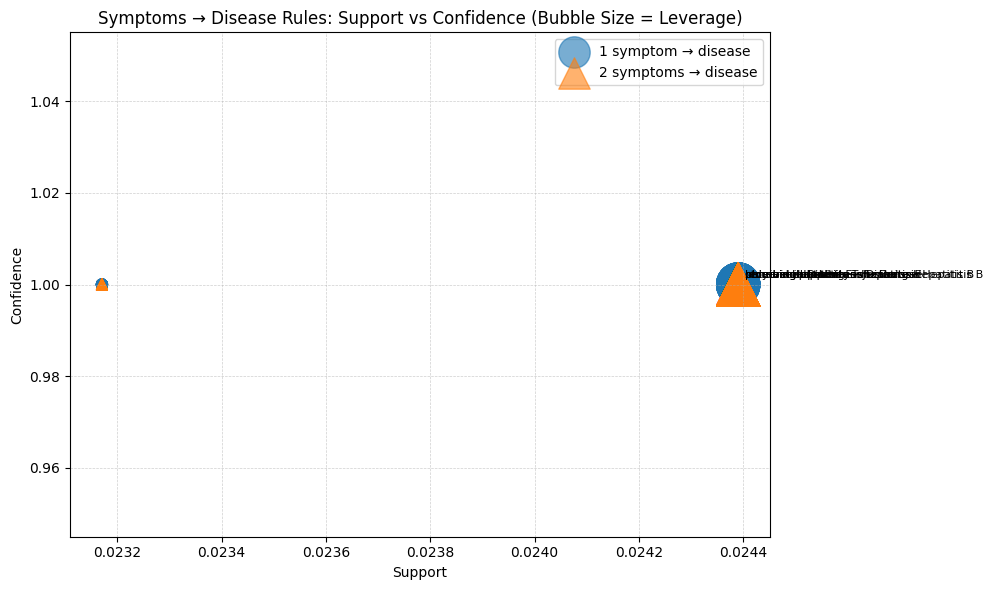

In [7]:
plot_df = rules_sd_df.copy()

# Keep a manageable set for a readable plot:
# prioritize confident rules, then keep top by leverage
plot_df = plot_df.sort_values(["confidence","leverage","support"], ascending=False).head(180).copy()

# Size scaling from leverage (avoid tiny bubbles)
sizes = (plot_df["leverage"] - plot_df["leverage"].min()) / (plot_df["leverage"].max() - plot_df["leverage"].min() + 1e-9)
sizes = 60 + sizes * 900

plt.figure(figsize=(10,6))

mask1 = plot_df["antecedent_len"] == 1
mask2 = plot_df["antecedent_len"] == 2

plt.scatter(plot_df.loc[mask1, "support"], plot_df.loc[mask1, "confidence"], s=sizes[mask1], alpha=0.6, marker="o", label="1 symptom → disease")
plt.scatter(plot_df.loc[mask2, "support"], plot_df.loc[mask2, "confidence"], s=sizes[mask2], alpha=0.6, marker="^", label="2 symptoms → disease")

plt.title("Symptoms → Disease Rules: Support vs Confidence (Bubble Size = Leverage)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.legend()

# Annotate a few standout rules
to_annotate = plot_df.sort_values(["confidence","leverage","support"], ascending=False).head(8)
for _, r in to_annotate.iterrows():
    label = f"{r['antecedent_str']} → {r['disease']}"
    plt.annotate(label, (r["support"], r["confidence"]), fontsize=8, xytext=(5,5), textcoords="offset points")

plt.tight_layout()
plt.show()


## Visual 4 — Bipartite network (Symptoms → Diseases)

This network highlights the strongest **single-symptom → disease** rules (cleanest to interpret).  
Edges are weighted by confidence, so thicker edges indicate more reliable relationships.


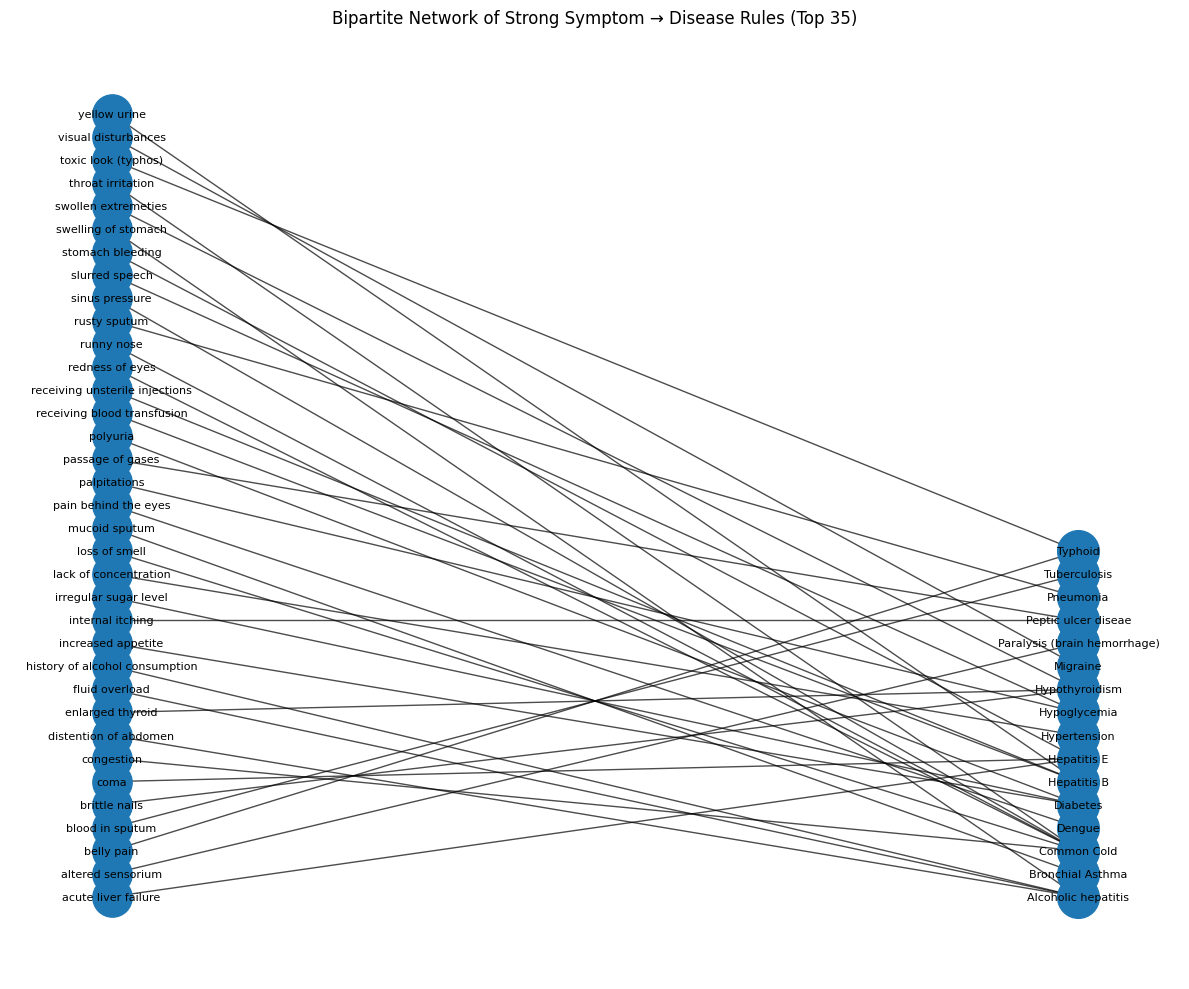

,antecedent_str,disease,support,confidence,lift,leverage
39,increased appetite,Diabetes,0.02439,1.0,41.0,0.023795
43,polyuria,Diabetes,0.02439,1.0,41.0,0.023795
115,pain behind the eyes,Dengue,0.02439,1.0,41.0,0.023795
149,receiving blood transfusion,Hepatitis B,0.02439,1.0,41.0,0.023795
150,receiving unsterile injections,Hepatitis B,0.02439,1.0,41.0,0.023795
170,coma,Hepatitis E,0.02439,1.0,41.0,0.023795
177,stomach bleeding,Hepatitis E,0.02439,1.0,41.0,0.023795
189,blood in sputum,Tuberculosis,0.02439,1.0,41.0,0.023795
207,congestion,Common Cold,0.02439,1.0,41.0,0.023795
213,loss of smell,Common Cold,0.02439,1.0,41.0,0.023795


In [8]:
# Select top edges for readability
edges_df = (rules_sd_df[rules_sd_df["antecedent_len"] == 1]
            .sort_values(["confidence","support","leverage"], ascending=False)
            .head(35)
            .copy())

G = nx.Graph()

sym_nodes = set(edges_df["antecedent_str"].tolist())
dis_nodes = set(edges_df["disease"].tolist())

for s in sym_nodes:
    G.add_node(s, bipartite=0)
for d in dis_nodes:
    G.add_node(d, bipartite=1)

for _, r in edges_df.iterrows():
    s = r["antecedent_str"]
    d = r["disease"]
    G.add_edge(s, d, weight=float(r["confidence"]))

# Bipartite layout: symptoms on left, diseases on right
left = sorted(sym_nodes)
right = sorted(dis_nodes)

pos = {}
for i, node in enumerate(left):
    pos[node] = (0, i)
for i, node in enumerate(right):
    pos[node] = (1.0, i)

weights = [G[u][v]["weight"] for u, v in G.edges()]
w_min, w_max = min(weights), max(weights)
widths = [1 + 6 * ((w - w_min) / (w_max - w_min + 1e-9)) for w in weights]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, nodelist=left, node_size=800)
nx.draw_networkx_nodes(G, pos, nodelist=right, node_size=900)
nx.draw_networkx_edges(G, pos, width=widths, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Bipartite Network of Strong Symptom → Disease Rules (Top 35)")
plt.axis("off")
plt.tight_layout()
plt.show()

display(edges_df[["antecedent_str","disease","support","confidence","lift","leverage"]].head(12))


## Quick demonstration: rule-based suggestion

This small demo shows how mined rules can be used to rank likely diseases for a symptom set.  
It simply matches applicable rules and aggregates their confidence (a transparent baseline approach).


In [9]:
def suggest_diseases(symptom_list, rules_df, top_n=5):
    sset = set([clean_symptom_token(s) for s in symptom_list])
    # keep only symptom->disease rules (antecedent is symptoms)
    candidates = []
    for _, r in rules_df.iterrows():
        ant = set(r["antecedent"])
        # ignore disease items in antecedent (shouldn't exist here)
        if any(is_disease(x) for x in ant):
            continue
        if ant.issubset(sset):
            candidates.append(r)

    if not candidates:
        return pd.DataFrame(columns=["disease","score","matched_rule_count"])

    cand_df = pd.DataFrame(candidates)
    # simple scoring: sum of confidence, plus tie-breakers on support
    grouped = (cand_df.groupby("disease")
               .agg(score=("confidence","sum"),
                    matched_rule_count=("confidence","count"),
                    avg_support=("support","mean"))
               .sort_values(["score","matched_rule_count","avg_support"], ascending=False)
               .head(top_n)
               .reset_index())
    return grouped

example_symptoms = ["nausea", "vomiting", "abdominal pain"]
result = suggest_diseases(example_symptoms, rules_sd_df, top_n=8)
print("Example symptoms:", example_symptoms)
display(result)


Example symptoms: ['nausea', 'vomiting', 'abdominal pain']


,disease,score,matched_rule_count,avg_support
0,Hepatitis E,0.725572,6,0.023171
1,Chronic cholestasis,0.701872,6,0.022561
2,Hepatitis D,0.701872,6,0.022561
3,Typhoid,0.701872,6,0.022561
4,hepatitis A,0.701872,6,0.022561
5,Alcoholic hepatitis,0.294164,3,0.022764
6,Jaundice,0.294164,3,0.022764
7,Peptic ulcer diseae,0.294164,3,0.022764


## Conclusion

### Key results
- The dataset contains **balanced disease classes** and a wide variety of symptom combinations, making it suitable for ARM-based pattern discovery.
- Symptom frequency and Jaccard similarity reveal clusters of symptoms that tend to appear together.
- High-confidence symptom→disease rules exist for several diseases, and two-symptom rules provide more specific patterns when needed.

### Limitations
- Balanced disease counts inflate lift for symptom→disease rules; leverage and support/confidence provide a more grounded interpretation.
- This dataset is not real-world prevalence data and does not represent clinical diagnosis conditions.

### Next steps (if extending the project)
- Evaluate rules on a held-out split to test generalization.
- Build an interactive rule explorer (filters by disease, confidence, support).
- Compare ARM-based suggestions with a simple baseline classifier for benchmarking.
